In [1]:
import pandas as pd
import DataLoading
import NN_classes
import NN_evaluation
import torch
import matplotlib.pyplot as plt

In [2]:
sc = "sc01"
period = "2030"
folder = "../Data/3-bus_AC_12w_ext_o_dummy_LCOE/"
folder = "../Data/9n_AC_12w_ext_o_dummy_LCOE/"
all_executions = DataLoading.list_executions(folder=folder,per = period,sc=sc)
te_s = 0.3
val_s = 0.4

In [3]:
dfs_in, dfs_out, dfs_inter = DataLoading.load_data_ext_out(folder, all_executions, period, sc, ["PowerFlow"])

input_f_sc01_Network_Existing_Generation_Full_2030.csv
24
input_f_sc01_Network_Line_In_Node_1_Node_6_cac1_2030.csv
24
input_f_sc01_Network_Line_In_Node_2_Node_3_cac1_2030.csv
24
input_f_sc01_Network_Line_In_Node_2_Node_6_cac1_2030.csv
24
input_f_sc01_Network_Line_In_Node_3_Node_4_cac1_2030.csv
24
input_f_sc01_Network_Line_In_Node_3_Node_6_cac1_2030.csv
24
input_f_sc01_Network_Line_In_Node_4_Node_5_cac1_2030.csv
24
input_f_sc01_Network_Line_In_Node_4_Node_6_cac1_2030.csv
24
input_f_sc01_Network_Line_In_Node_4_Node_9_cac1_2030.csv
24
input_f_sc01_Network_Line_In_Node_6_Node_7_cac1_2030.csv
24
input_f_sc01_Network_Line_In_Node_6_Node_8_cac1_2030.csv
24
input_f_sc01_Network_Line_In_Node_7_Node_8_cac1_2030.csv
24
input_f_sc01_Network_Line_In_Node_8_Node_9_cac1_2030.csv
24


In [4]:
dfs_inter_j = DataLoading.join_frames_inter_layer(dfs_inter)
dfs_inter_j = DataLoading.trim_columns_to_common(dfs_inter_j)
# Convert to pytorch tensors
ts_in, ts_out, ts_inter = DataLoading.split_tr_val_te_ext_out(dfs_in, dfs_out, dfs_inter_j, all_executions, te_s, val_s)
d_ft_in, d_ft_out, d_ft_inter,maxs = DataLoading.concat_and_normalize_ext_out(ts_in, ts_out, ts_inter, all_executions)

input_size = dfs_in["Network_Existing_Generation_Full"].shape[1]
inter_size = dfs_inter_j["Network_Existing_Generation_Full"].shape[1]

In [23]:
#Find model with best loss from csv file 
hyperloop_name = "RTS24_AC_12w_dummy_0.3_v0.4_PF_sa_rand_0_40"
hyperloop_name ="3-bus_AC_12w_dummy_0.3_v0.4_PF_LCOE_0_10"
hyperloop_name = "9n_AC_12w_dummy_0.3_v0.4_PF_LCOE_0_13"

df_losses = pd.read_csv(f"ResultsClusterRuns/Loss_results_csv/{hyperloop_name}.csv",index_col=0)
#df_losses = pd.read_csv(f"Loss_results_csv/{hyperloop_name}.csv",index_col=0)

f = df_losses.alpha ==0.16

loss_to_sort = "Te_l_t_mse"

xth_best = 1
row = NN_evaluation.find_xthbest_model_params_from_df(df_losses[f],loss_to_sort,xth_best)
m = NN_evaluation.create_model_and_load_state_from_row(row,input_size,inter_size,hyperloop_name,cluster_run=True)

[48, 18, 12]


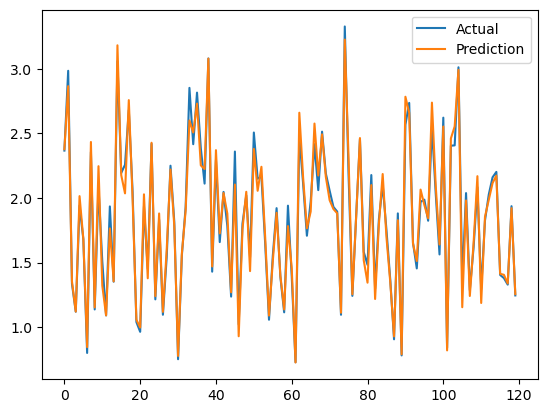

In [24]:
#Visual sanity check
ex = all_executions[0]
data_part = "train"
# actual = calculate_lb_from_dfs_out(dfs_out,ex)
actual = 0
ex_in = torch.nan_to_num(ts_in[data_part][ex]/maxs["in"])
ex_out_1 = ts_out[data_part][ex]
ex_out = dfs_out[ex].sum(axis=1)

prediction = m(ex_in.float())[0].detach().numpy()

s = 0
e=s+120
#plt.plot(ex_out[s:e],label = "Actual")
plt.plot(ex_out_1[s:e],label = "Actual")

plt.plot(prediction[s:e],label = "Prediction")

plt.legend()

[48, 72, 18, 12]


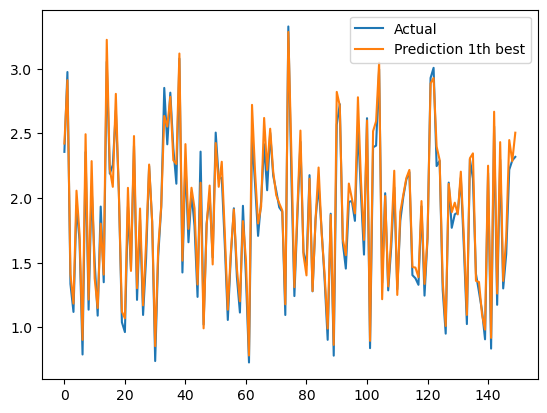

In [17]:
#Visualisation of multiple models in the shuffled order used for training 
ex = all_executions[1]
data_part = "train"
actual = NN_evaluation.calculate_lb_from_dfs_out(dfs_out,ex)
ex_in = torch.nan_to_num(ts_in[data_part][ex]/maxs["in"])
ex_out_1 = ts_out[data_part][ex]
s = 0
e=s+150
plt.plot(ex_out_1[s:e],label = "Actual")
cluster_run = True

for xth_best in [1]: 
    row = NN_evaluation.find_xthbest_model_params_from_df(df_losses[f],loss_to_sort,xth_best)
    m = NN_evaluation.create_model_and_load_state_from_row(row,input_size,inter_size,hyperloop_name,cluster_run)
    prediction = m(ex_in.float())[0].detach().numpy()
    plt.plot(prediction[s:e],label = f"Prediction {xth_best}th best")
plt.legend()


[48, 18, 12]


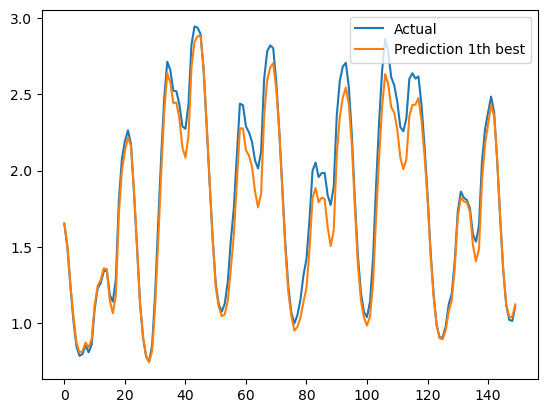

In [25]:
#Visualisation of multiple models in input order
ex = all_executions[0]
cluster_run =True

#ex_in = torch.nan_to_num(ts_in[data_part][ex]/maxs["in"])
ex_in = torch.nan_to_num(dfs_in[ex].to_numpy()/maxs["in"])
ex_out = dfs_out[ex].sum(axis=1).to_numpy()

s = 0
e=s+150
plt.plot(ex_out[s:e],label = "Actual")

for xth_best in [1]: 
    row = NN_evaluation.find_xthbest_model_params_from_df(df_losses[f],loss_to_sort,xth_best)
    m = NN_evaluation.create_model_and_load_state_from_row(row,input_size,inter_size,hyperloop_name,cluster_run=cluster_run)
    prediction = m(ex_in.float())[0].detach().numpy()
    plt.plot(prediction[s:e],label = f"Prediction {xth_best}th best")
plt.legend()

Text(0.5, 1.0, 'Line benefit Network_Line_In_Node_1_Node_6_cac1')

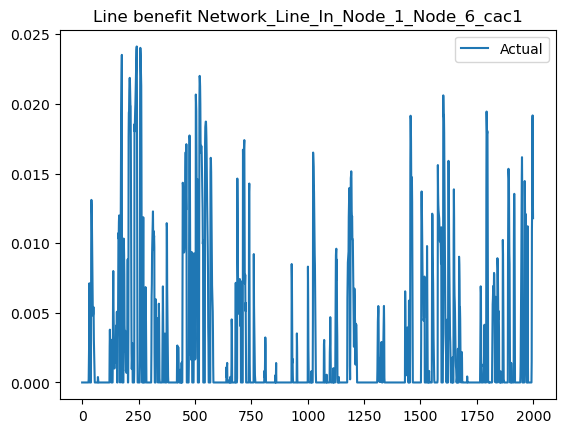

In [22]:
#Find estimated line benefits
ex = all_executions[1]
negf = all_executions[0]


ex_in_e = torch.nan_to_num(torch.concat((ts_in["train"][ex],ts_in["test"][ex],ts_in["val"][ex]))/maxs["in"])
ex_in_negf = torch.nan_to_num(torch.concat((ts_in["train"][negf],ts_in["test"][negf],ts_in["val"][negf]))/maxs["in"])

ex_in_e = torch.nan_to_num(dfs_in[ex].to_numpy()/maxs["in"])
ex_in_negf = torch.nan_to_num(dfs_in[negf].to_numpy()/maxs["in"])

prediction_e = m(ex_in_e.float())[0].detach().numpy()
prediction_negf = m(ex_in_negf.float())[0].detach().numpy()

lb_est = prediction_negf- prediction_e
lb_actual = NN_evaluation.calculate_lb_from_dfs_out(dfs_out,ex)
# lb_actual = calculate_lb_from_ts_out(ts_out,ex)


#ex_out = dfs_out[e].sum(axis=1)

s=0
e = s+2000
#plt.plot(lb_est[s:e],label = "NN Estimate")
plt.plot(lb_actual[s:e],label = "Actual")
plt.legend()
plt.title(f"Line benefit {ex}")
# plt.savefig(f"Figures/LineBenefits/Hourly_benefit{ex}")

In [ ]:
#Checking some randomisation stuff
import numpy as np
seed=0
arr_in = torch.nan_to_num(dfs_in[ex].to_numpy()/maxs["in"])
arr_out = dfs_out[ex].to_numpy().sum(axis=1)

rng = np.random.default_rng(seed)
shuffled_in = torch.from_numpy(rng.permutation(arr_in,axis=0))

rng = np.random.default_rng(seed)
shuffled_out = rng.permutation(arr_out,axis=0)
# shuffled_in = arr_in
# shuffled_out = arr_out
prediction_shuffled = m(shuffled_in.float())[0].detach().numpy()

# rng = np.random.default_rng(seed)
# prediction_shuffled_2 = rng.permutation(m(arr_in.float())[0].detach().numpy(),axis=0)
# rng = np.random.default_rng(seed)

# prediction_shuffled_3 = rng.permutation(m(arr_in.float())[0].detach().numpy(),axis=0)
# prediction_shuffled_2 = rng.permutation(m(arr_in.float())[0].detach().numpy(),axis=0)
# prediction_shuffled_3 = rng.permutation(m(arr_in.float())[0].detach().numpy(),axis=0)

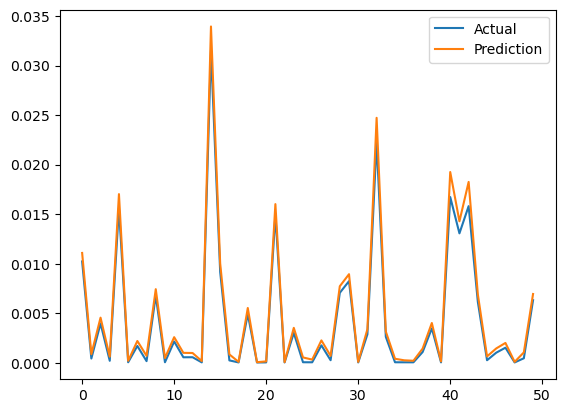

In [61]:
s=0
e=50
plt.plot(shuffled_out[s:e],label="Actual")
#plt.plot(arr_out[s:e],label="Actual")
plt.plot(prediction_shuffled[s:e],label="Prediction")
plt.legend()